# rmsd

This [Python program](https://github.com/charnley/rmsd) is available as the `rmsd` package. Its specific purpose is better described by its readme title: **Calculate Root-mean-square deviation (RMSD) of Two Molecules Using Rotation**.

It determines the structural differences between two molecules after aligning them (rotate, translate). It calculates the optimal rotational matrix to minimize the root-mean-square deviation (RMSD), which is often used to calculate the differences between modeled and observed values. This is done using either the [Kabsch algorithm](https://en.wikipedia.org/wiki/Kabsch_algorithm) (which uses SVD) or the [Quarternion algorithm](http://dx.doi.org/10.1016/1049-9660(91)90036-o) to calculate the rotation matrix. Due to its application on molecules, the primary audience is those in cheminformatics (comparing molecular structure) or bioinformatics (comparing protein structures) ([Wikipedia](https://en.wikipedia.org/wiki/Kabsch_algorithm); this repo is also featured under "External Links").

It can be installed using pip:
```
pip install rmsd
```
The rmsd repo also documents [an alternative installation method](https://github.com/charnley/rmsd#installation).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from timeit import default_timer as timer

import rmsd

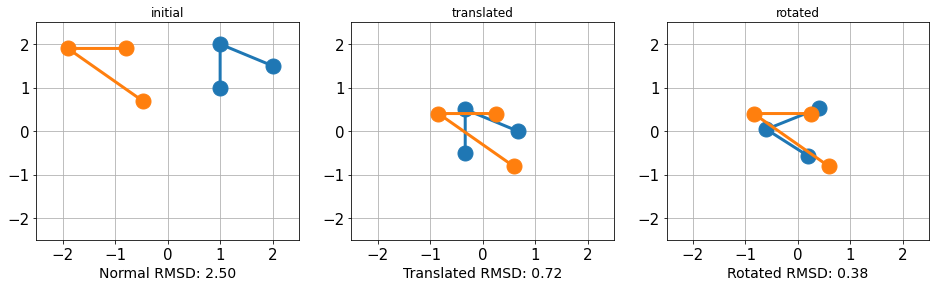

In [2]:
# code modified from example.py in the rmsd repo

# helper functions
def rotation_matrix(sigma: float) -> ndarray:
    """
    https://en.wikipedia.org/wiki/Rotation_matrix
    """

    radians = sigma * np.pi / 180.0

    r11 = np.cos(radians)
    r12 = -np.sin(radians)
    r21 = np.sin(radians)
    r22 = np.cos(radians)

    R = np.array([[r11, r12], [r21, r22]])

    return R

fig, ax = plt.subplots(1, 3, figsize=(16,4))

def save_plot(A: ndarray, B: ndarray, title, label, subplot) -> None:

    Ax = A[:, 0]
    Ay = A[:, 1]

    Bx = B[:, 0]
    By = B[:, 1]

    ax[subplot].plot(Ax, Ay, "o-", markersize=15, linewidth=3)
    ax[subplot].plot(Bx, By, "o-", markersize=15, linewidth=3)
    
    ax[subplot].set_title(title)
    ax[subplot].set_xlabel(label, fontsize=14)

    ax[subplot].set_ylim([-2.5, 2.5])
    ax[subplot].set_xlim([-2.5, 2.5])
    ax[subplot].grid(True)
    ax[subplot].tick_params(labelsize=15)

# molecules
A = np.array([[1.0, 1.0], [1.0, 2.0], [2.0, 1.5]])
B = np.array([[2.1, 2.3], [1.0, 1.0], [1.0, 2.0]])
B *= 1.1
B -= 3
B = np.dot(B, rotation_matrix(90))

label = "Normal RMSD: {:.2f}".format(rmsd.rmsd(A, B))
save_plot(A, B, title="initial", label=label, subplot=0)

# Translate
A1 = A - rmsd.centroid(A)
B1 = B - rmsd.centroid(B)

label = "Translated RMSD: {:.2f}".format(rmsd.rmsd(A1, B1))
save_plot(A1, B1, title="translated", label=label, subplot=1)

# Rotate using Kabsch
U = rmsd.kabsch(A1, B1)
A2 = np.dot(A1, U)

label = "Rotated RMSD: {:.2f}".format(rmsd.rmsd(A2, B1))
save_plot(A2, B1, title="rotated", label=label, subplot=2)

In [3]:
# or do the rotation and translation in one step
A3 = rmsd.kabsch_fit(A,B)

rmsd.rmsd(A3, B)

0.3831573138486592

Besides choosing between Kabsch and Quaternion for rotation, there are many other options. The cli `--help` message includes these parameters:

```
  -r METHOD, --rotation METHOD
                        select rotation method. Valid methods are kabsch,
                        quaternion, none. Default is Kabsch.
  -e, --reorder         align the atoms of molecules
  --reorder-method METHOD
                        select reorder method. Valid method are none, qml,
                        hungarian, inertia-hungarian, brute, distance. Default
                        is Hungarian.
```

The reorder methods are used for when the order of atoms are scrambled.

The rmsd repo also includes pytests and a `resources` folder that contains many `.xyz` files (molecules) to play around with. In the example below, we try out the different reordering methods on a set of 16 water molecules vs the same set but scrambled:

In [4]:
methods = ["hungarian", "distance", "brute"]
files = ["./water_16.xyz", "./water_16_idx.xyz"]

for method in methods:
    print(method, "\n\tresult - ", end="")
    start = timer()
    rmsd.main(["-e", "--reorder-method", method, files[0], files[1]])
    end = timer()
    print("\ttime - ", end - start)
    
# warning: brute force takes too long - interrupt the kernel if you need to

hungarian 
	result - 1.1433604409815158e-15
	time -  0.005212750000000099
distance 
	result - 1.1433604409815158e-15
	time -  0.0018254170000000514
brute 
	result - 

### Question

One question I have about this program is about why certain methods are given as options. As in, why are both Kabsch and Quaternion offered - and what are the tradeoffs for each? Similarly for the reordering methods, why is brute force offered when it's extremely slow?

### Possible experiment

In the same vein as my question, I think observing the speed and/or accuracy of Kabsch vs Quaternion could help give a more tangible comparison between the two methods. This would involve making # of points vs time graphs.